<a href="https://colab.research.google.com/github/Thunamjyothika/DL-Assignment2/blob/main/DL_ASSIGNMENT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
import os
tar_path = "/content/dakshina_dataset_v1.0.tar"

# Extract it to a folder
extracted_path = "/content/dakshina_dataset_v1.0"

if not os.path.exists(extracted_path):
    with tarfile.open(tar_path) as tar:
        tar.extractall(path="/content/")

# Now access the lexicon files properly
data_dir = os.path.join(extracted_path, "hi")

train_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
val_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")
test_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv")

def load_data(path):
    import pandas as pd
    data = pd.read_csv(path, sep="\t", header=None)
    data.columns = ['hi', 'latin', 'count']
    return data

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)


In [ ]:
import os
import pandas as pd

data_dir = "/content/dakshina_dataset_v1.0.tar"

# Training, validation and test files
train_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
val_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")
test_path = os.path.join(data_dir, "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv")

# Load data
def load_data(path):
    data = pd.read_csv(path, sep="\t", header=None)
    data.columns = ['hi', 'latin', 'count']
    return data[['hi', 'latin']]

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)


In [ ]:
def clean_data(data, source_col='latin', target_col='hi'):
    data = data.dropna(subset=[source_col, target_col])
    data[source_col] = data[source_col].astype(str)
    data[target_col] = data[target_col].astype(str)
    return data

train_data = clean_data(train_data)
val_data = clean_data(val_data)
test_data = clean_data(test_data)


<ipython-input-15-a335b16649d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[source_col] = data[source_col].astype(str)
<ipython-input-15-a335b16649d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_col] = data[target_col].astype(str)


In [ ]:
def create_vocab(data, source_col, target_col):
    source_vocab = set()
    target_vocab = set()

    for _, row in data.iterrows():
        source_vocab.update(list(row[source_col]))
        target_vocab.update(list(row[target_col]))

    source_vocab = sorted(list(source_vocab))
    target_vocab = sorted(list(target_vocab))

    source_token_index = {char: i+1 for i, char in enumerate(source_vocab)}  # 0 = padding
    target_token_index = {char: i+1 for i, char in enumerate(target_vocab)}

    reverse_target_token_index = {i: char for char, i in target_token_index.items()}

    return source_token_index, target_token_index, reverse_target_token_index


In [ ]:
def create_vocab(data, source_col, target_col):
    source_vocab = set()
    target_vocab = set()

    for _, row in data.iterrows():
        source_vocab.update(list(row[source_col]))
        target_vocab.update(list(row[target_col]))

    # Add start and end tokens for decoder vocab
    target_vocab.update(['\t', '\n'])

    source_vocab = sorted(list(source_vocab))
    target_vocab = sorted(list(target_vocab))

    # Assign index starting from 0 for padding
    source_token_index = {char: i for i, char in enumerate(source_vocab)}  # Padding at index 0
    target_token_index = {char: i for i, char in enumerate(target_vocab)}   # Padding at index 0

    reverse_target_token_index = {i: char for char, i in target_token_index.items()}

    return source_token_index, target_token_index, reverse_target_token_index


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def vectorize(data, source_token_index, target_token_index, max_encoder_len, max_decoder_len):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []

    for _, row in data.iterrows():
        input_text = row['latin']
        target_text = row['hi']

        # Add start and end tokens
        target_text = '\t' + target_text + '\n'

        # Encoder sequence
        encoder_seq = [source_token_index[char] for char in input_text]

        # Decoder input and output
        decoder_seq = [target_token_index[char] for char in target_text]

        decoder_input_seq = decoder_seq[:-1]
        decoder_target_seq = decoder_seq[1:]

        encoder_input_data.append(encoder_seq)
        decoder_input_data.append(decoder_input_seq)
        decoder_target_data.append(decoder_target_seq)

    # Padding the sequences to a consistent length
    encoder_input_data = pad_sequences(encoder_input_data, maxlen=max_encoder_len, padding='post')
    decoder_input_data = pad_sequences(decoder_input_data, maxlen=max_decoder_len, padding='post')
    decoder_target_data = pad_sequences(decoder_target_data, maxlen=max_decoder_len, padding='post')

    # One-hot encode the target data
    num_decoder_tokens = len(target_token_index)
    decoder_target_data = to_categorical(decoder_target_data, num_classes=num_decoder_tokens)

    return encoder_input_data, decoder_input_data, decoder_target_data


Epoch 1/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 71s 104ms/step - accuracy: 0.7060 - loss: 1.3041 - val_accuracy: 0.7383 - val_loss: 0.9885
Epoch 2/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.7606 - loss: 0.8711 - val_accuracy: 0.7455 - val_loss: 0.9397
Epoch 3/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.7857 - loss: 0.7532 - val_accuracy: 0.7711 - val_loss: 0.8465
Epoch 4/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.8239 - loss: 0.6039 - val_accuracy: 0.8042 - val_loss: 0.7133
Epoch 5/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.8590 - loss: 0.4703 - val_accuracy: 0.8226 - val_loss: 0.6203
Epoch 6/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.8861 - loss: 0.3698 - val_accuracy: 0.8473 - val_loss: 0.5180
Epoch 7/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.9048 - loss: 0.3041 - val_accuracy: 0.8600 - val_loss: 0.4658
Epoch 8/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.9179 - loss: 0.2

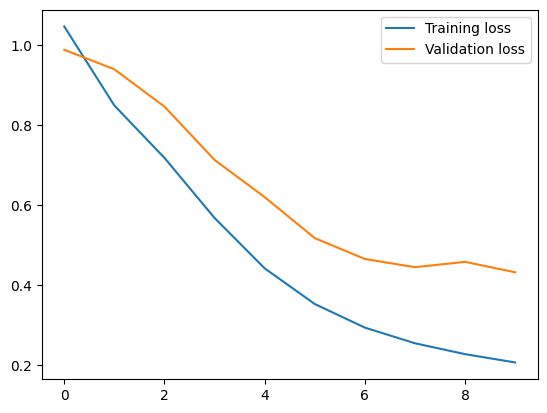

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SimpleRNN, Dense

def build_model(cell_type='LSTM', embedding_dim=64, hidden_dim=128):
    encoder_inputs = Input(shape=(None,))
    decoder_inputs = Input(shape=(None,))
    encoder_emb = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)
    decoder_emb = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim)(decoder_inputs)

    RNN_Cell = {'RNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}[cell_type]

    # Encoder
    if cell_type == 'LSTM':
        encoder_outputs, state_h, state_c = RNN_Cell(hidden_dim, return_state=True)(encoder_emb)
        encoder_states = [state_h, state_c]
    else:
        encoder_outputs, state_h = RNN_Cell(hidden_dim, return_state=True)(encoder_emb)
        encoder_states = [state_h]

    # Decoder
    if cell_type == 'LSTM':
        decoder_rnn = RNN_Cell(hidden_dim, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_rnn(decoder_emb, initial_state=encoder_states)
    else:
        decoder_rnn = RNN_Cell(hidden_dim, return_sequences=True, return_state=True)
        decoder_outputs, _ = decoder_rnn(decoder_emb, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

encoder_input_data, decoder_input_data, decoder_target_data = vectorize(
    train_data, source_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length
)
num_decoder_tokens = len(target_token_index)
model = build_model(cell_type='LSTM', embedding_dim=64, hidden_dim=128)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=10,
    validation_split=0.1
)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

encoder_inputs_inf = model.input[0]
encoder_emb_layer = model.layers[2]
encoder_rnn = model.layers[4]

encoder_emb_inf = encoder_emb_layer(encoder_inputs_inf)
_, state_h_enc, state_c_enc = encoder_rnn(encoder_emb_inf)
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs_inf, encoder_states)


In [ ]:
# Decoder setup
decoder_inputs_inf = model.input[1]
decoder_emb_layer = model.layers[3]
decoder_rnn = model.layers[5]
decoder_dense = model.layers[6]

decoder_state_input_h = Input(shape=(128,))
decoder_state_input_c = Input(shape=(128,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_emb_inf = decoder_emb_layer(decoder_inputs_inf)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_rnn(
    decoder_emb_inf, initial_state=decoder_states_inputs
)
decoder_states_inf = [state_h_inf, state_c_inf]

decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)


In [ ]:
# Example input text
example_input = "namaste"

def encode_input(text):
    seq = [source_token_index.get(char, 0) for char in text]
    return pad_sequences([seq], maxlen=max_encoder_seq_length, padding='post')

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['\t']

    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, *states_value = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_token_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip()

# Encode and predict
input_seq = encode_input(example_input)
predicted_output = decode_sequence(input_seq)

# Show the result
print(f"Latin Input: {example_input}")
print(f"Predicted Devanagari Transliteration: {predicted_output}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Latin Input: namaste
Predicted Devanagari Transliteration: नमस्ते


In [ ]:
def predict_examples(examples):
    for input_text in examples:
        input_seq = [source_token_index[char] for char in input_text if char in source_token_index]
        input_seq = pad_sequences([input_seq], maxlen=max_encoder_seq_length, padding='post')
        decoded = decode_sequence(input_seq)
        print(f"Latin: {input_text} → Devanagari: {decoded}")


In [ ]:
sample_latin_words = [
    "namaste",
    "krishna",
    "bharat",
    "dilli",
    "shakti",
    "mantri",
    "prem",
    "ramayan",
    "yatra",
    "vishwa"
]

predict_examples(sample_latin_words)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Latin: namaste → Devanagari: नमस्ते
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Latin: krishna → Devanagari: कृष्ण
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Latin: bharat → Devanagari: भरता
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━

In [ ]:

def evaluate_model(test_data):
    correct = 0
    total = 0
    for _, row in test_data.iterrows():
        input_text = row['latin']
        true_text = row['hi']
        input_seq = encode_input(input_text)
        pred_text = decode_sequence(input_seq)

        if pred_text == true_text:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy * 100:.2f}%")
    return accuracy



In [ ]:
evaluate_model(test_data.sample(100))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

0.2

In [ ]:
# @title Default title text
Question-2
import zipfile
import os

file_path = '/content/archive.zip'
extract_dir = '/content/extracted_data'

try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully extracted '{file_path}' to '{extract_dir}'")

    for root, dirs, files in os.walk(extract_dir):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'")
except zipfile.BadZipFile:
    print(f"Error: Could not open or read the zip file '{file_path}'. It might be corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully extracted '/content/archive.zip' to '/content/extracted_data'
Directory: /content/extracted_data
Directory: /content/extracted_data/csv
  File: BillieEilish.csv
  File: NickiMinaj.csv
  File: ColdPlay.csv
  File: DuaLipa.csv
  File: JustinBieber.csv
  File: EdSheeran.csv
  File: LadyGaga.csv
  File: CardiB.csv
  File: Khalid.csv
  File: Maroon5.csv
  File: Drake.csv
  File: Eminem.csv
  File: Beyonce.csv
  File: Rihanna.csv
  File: BTS.csv
  File: KatyPerry.csv
  File: CharliePuth.csv
  File: SelenaGomez.csv
  File: TaylorSwift.csv
  File: PostMalone.csv
  File: ArianaGrande.csv
Directory: /content/extracted_data/json files
  File: Lyrics_JustinBieber.json
  File: Lyrics_LadyGaga.json
  File: Lyrics_BillieEilish.json
  File: Lyrics_SelenaGomez.json
  File: Lyrics_TaylorSwift.json
  File: Lyrics_Beyonc.json
  File: Lyrics_BTS.json
  File: Lyrics_KatyPerry.json
  File: Lyrics_NickiMinaj.json
  File: Lyrics_Rihanna.json
  File: Lyrics_Eminem.json
  File: Lyrics_Drake.json
  F

In [ ]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import load_dataset

def load_lyrics_from_text(file_paths):
    lines = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    lines.append(line)
    return {"text": lines}

lyric_file_paths = ['/content/extracted_data/csv/JustinBieber.csv', '/content/extracted_data/json files/Lyrics_JustinBieber.json']
raw_dataset = load_dataset("text", data_files=lyric_file_paths)

print(raw_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 185414
    })
})


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
block_size = 128

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=block_size)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, num_proc=4)

tokenized_dataset = tokenized_dataset.remove_columns(["text"])

Map (num_proc=4):   0%|          | 0/185414 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments

output_dir = "./gpt2-lyrics"
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=1000,
    save_total_limit=2,
    prediction_loss_only=True,
    learning_rate=5e-5,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=lambda data: {'input_ids': torch.stack([f['input_ids'] for f in data]),
                               'attention_mask': torch.stack([f['attention_mask'] for f in data]),
                               'labels': torch.stack([f['input_ids'] for f in data])},
)

trainer.train()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import os

In [ ]:
block_size = 128
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=block_size)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, num_proc=os.cpu_count()) # Use available CPUs
tokenized_dataset = tokenized_dataset.remove_columns(["text"])

Map (num_proc=2):   0%|          | 0/185414 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["main"] if "main" in tokenized_dataset else tokenized_dataset["train"],
    data_collator=lambda data: {'input_ids': torch.stack([f['input_ids'] for f in data]),
                               'attention_mask': torch.stack([f['attention_mask'] for f in data]),
                               'labels': torch.stack([f['input_ids'] for f in data])},
)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import os

lyric_file_paths = ['/content/extracted_data/csv/JustinBieber.csv']
raw_dataset = load_dataset("text", data_files=lyric_file_paths)
print(f"Raw dataset: {raw_dataset}")

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

block_size = 128
def tokenize_function(examples):
    result = tokenizer(examples["text"], truncation=True, padding='max_length', max_length=block_size)
    return result

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, num_proc=os.cpu_count())
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
print(f"Tokenized dataset: {tokenized_dataset}")

print("Example from tokenized_dataset:")
print(tokenized_dataset["train"][0])
print(tokenized_dataset["train"][1])

output_dir = "./gpt2-lyrics"
training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    save_steps=500,
    save_total_limit=1,
    prediction_loss_only=True,
    learning_rate=5e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=lambda data: {'input_ids': torch.stack([f['input_ids'] for f in data]),
                               'attention_mask': torch.stack([f['attention_mask'] for f in data]),
                               'labels': torch.stack([f['input_ids'] for f in data])},
)


Generating train split: 0 examples [00:00, ? examples/s]

Raw dataset: DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 349
    })
})


Map (num_proc=2):   0%|          | 0/349 [00:00<?, ? examples/s]

Tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 349
    })
})
Example from tokenized_dataset:
{'input_ids': [11, 43020, 11, 19160, 11, 2348, 4435, 11, 17688, 11, 10430, 11, 31633, 1173, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

In [ ]:
import torch
from transformers import Trainer

def data_collator(examples):
    input_ids = [example['input_ids'] for example in examples]
    attention_mask = [example['attention_mask'] for example in examples]
    labels = [example['input_ids'] for example in examples]  # For causal LM

    return {
        'input_ids': torch.tensor(input_ids),
        'attention_mask': torch.tensor(attention_mask),
        'labels': torch.tensor(labels)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=88, training_loss=3.2414526505903765, metrics={'train_runtime': 909.2098, 'train_samples_per_second': 0.384, 'train_steps_per_second': 0.097, 'total_flos': 22797729792000.0, 'train_loss': 3.2414526505903765, 'epoch': 1.0})

In [ ]:
trainer.save_model("./fine-tuned-gpt2-lyrics")
tokenizer.save_pretrained("./fine-tuned-gpt2-lyrics")

print("Fine-tuning complete. Model saved to ./fine-tuned-gpt2-lyrics")

def generate_lyrics(prompt, max_length=200, num_return_sequences=3, temperature=0.8):
    finetuned_model = AutoModelForCausalLM.from_pretrained("./fine-tuned-gpt2-lyrics").to(model.device)
    finetuned_tokenizer = AutoTokenizer.from_pretrained("./fine-tuned-gpt2-lyrics")

    input_ids = finetuned_tokenizer.encode(prompt, return_tensors="pt").to(finetuned_model.device)

    output = finetuned_model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        temperature=temperature,
        pad_token_id=finetuned_tokenizer.eos_token_id,
        do_sample=True,
    )

    generated_lyrics = []
    for i in range(num_return_sequences):
        generated_text = finetuned_tokenizer.decode(output[i], skip_special_tokens=True)
        generated_lyrics.append(generated_text)
    return generated_lyrics

prompt = "The rain falls down on a lonely street,"
generated_lyrics = generate_lyrics(prompt)

print("\n--- Generated Lyrics ---")
for i, lyrics in enumerate(generated_lyrics):
    print(f"Generated Lyric {i+1}:\n{lyrics}\n---")



Fine-tuning complete. Model saved to ./fine-tuned-gpt2-lyrics

--- Generated Lyrics ---
Generated Lyric 1:
The rain falls down on a lonely street, and you stand there a moment in the rain, still on your knees crying and crying, then you run out to the street where you're a part of the fight and the fight is over, you've got the fight and you're going to win it now, right? You're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fight and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and you're still fighting and that's what's the thing that's the difference between th